### Predicting Tax Fraud Using XGBoost

#### Step 1: Generate Synthetic Data

First, we'll generate synthetic data that resembles real-world features typically found in tax-related datasets. For this example, we'll create features such as income, deductions, audit score, age, marital status, and number of dependents. We'll also simulate a binary target variable (`fraud_label`) indicating whether fraud was detected or not.

In [1]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 10000

# Simulated features
income = np.random.normal(50000, 15000, n_samples)  # Normal distribution for income
deductions = np.random.normal(10000, 5000, n_samples)  # Normal distribution for deductions
audit_score = np.random.uniform(0, 1, n_samples)  # Uniform distribution for audit score
age = np.random.randint(20, 70, n_samples)  # Random integers for age
is_married = np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4])  # Binary distribution for marital status
num_dependents = np.random.randint(0, 5, n_samples)  # Random integers for number of dependents

# Simulated target variable: 1 if fraud detected, 0 otherwise
# Adjusting probabilities based on features
fraud_prob = 1 / (1 + np.exp(-(deductions / 10000 - audit_score * 10 + income / 50000 - 0.5 * age / 70 + 0.1 * num_dependents - 2 * is_married + np.random.normal(0, 0.3, n_samples))))
fraud_label = np.random.binomial(1, fraud_prob)

# Create a DataFrame
data = pd.DataFrame({
    'income': income,
    'deductions': deductions,
    'audit_score': audit_score,
    'age': age,
    'is_married': is_married,
    'num_dependents': num_dependents,
    'fraud_label': fraud_label
})

# Display the first few rows of the data
data.head()

,income,deductions,audit_score,age,is_married,num_dependents,fraud_label
0,57450.712295,6607.526348,0.055666,50,0,1,1
1,47926.035482,8472.502685,0.985768,44,0,2,0
2,59715.328072,7013.094695,0.800018,27,0,2,0
3,72845.447846,10552.090235,0.868809,31,0,3,0
4,46487.699379,15985.892657,0.694294,21,1,4,0


### Visualizing Synthetic Data Distribution
First, let's visualize the distribution of some key features in our synthetic dataset:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

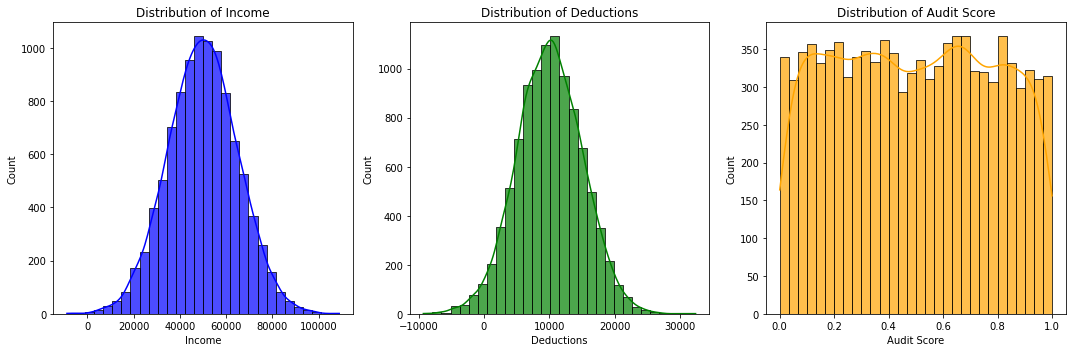

In [3]:
# Plot distributions of income, deductions, and audit_score
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(data['income'], bins=30, kde=True, color='blue', alpha=0.7)
plt.xlabel('Income')
plt.title('Distribution of Income')

plt.subplot(1, 3, 2)
sns.histplot(data['deductions'], bins=30, kde=True, color='green', alpha=0.7)
plt.xlabel('Deductions')
plt.title('Distribution of Deductions')

plt.subplot(1, 3, 3)
sns.histplot(data['audit_score'], bins=30, kde=True, color='orange', alpha=0.7)
plt.xlabel('Audit Score')
plt.title('Distribution of Audit Score')

plt.tight_layout()
plt.show()

#### Step 2: Prepare Data for Modeling

Next, we prepare the data for training and testing the XGBoost model. This involves separating the features (`X`) from the target variable (`y`) and splitting the data into training and testing sets.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# Separate features and target variable
X = data.drop('fraud_label', axis=1)
y = data['fraud_label']

In [6]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Display the shapes of the datasets
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (8000, 6), Testing set: (2000, 6)


#### Step 3: Train an XGBoost Model

Now, we'll define an XGBoost model and train it using the training data.

In [8]:
import xgboost as xgb

In [10]:
# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

Using DMatrix format in XGBoost ensures optimal performance, efficient memory usage, and seamless integration with the underlying C++ implementation. While it adds a step of conversion from traditional data structures, the benefits in terms of speed and scalability make it a preferred choice for working with large-scale datasets in XGBoost.

In [12]:
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [17]:
# Train the model
model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'Test')],
                  early_stopping_rounds=50, verbose_eval=50)

[0]	Test-auc:0.54214
[50]	Test-auc:0.90540
[92]	Test-auc:0.90456


#### Step 4: Evaluate the Model

After training the model, evaluate its performance on the test set using metrics such as accuracy, precision, recall, and ROC-AUC.

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [19]:
# Make predictions on the test set
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

In [20]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

In [21]:
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8880, Precision: 0.6667, Recall: 0.4916, ROC-AUC: 0.9046


### Visualizing Model Performance
Next, let's visualize the ROC curve for our XGBoost model to understand its performance:

In [22]:
from sklearn.metrics import roc_curve

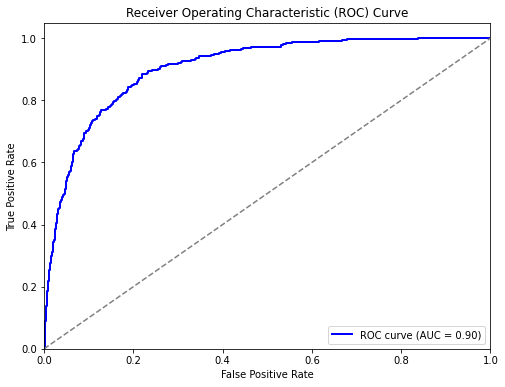

In [23]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Model Validation with New Sample

#### Step 1: Prepare the New Sample

In [24]:
# Example of a new sample (make sure the feature order matches the training data)
new_sample = {
    'income': 60000,
    'deductions': 15000,
    'audit_score': 0.7,
    'age': 45,
    'is_married': 1,
    'num_dependents': 2
}

In [25]:
# Convert the new sample to a DataFrame (if your model expects a DataFrame)
new_sample_df = pd.DataFrame([new_sample])

In [26]:
# Display the new sample
print(new_sample_df)

   income  deductions  audit_score  age  is_married  num_dependents
0   60000       15000          0.7   45           1               2


#### Step 2: Convert the New Sample to `DMatrix`

Convert the new sample to a `DMatrix` object, which is the format expected by XGBoost for predictions.

In [27]:
# Convert the new sample to DMatrix format
dnew = xgb.DMatrix(new_sample_df)

#### Step 3: Predict the Outcome

Use the trained model to make a prediction for the new sample.

In [28]:
# Predict the outcome for the new sample
new_sample_pred = model.predict(dnew)

In [29]:
# Since the output is a probability, convert it to a binary prediction if needed
new_sample_pred_binary = [1 if p >= 0.5 else 0 for p in new_sample_pred]

In [31]:
# Display the prediction
print(f"Predicted probability of fraud: {new_sample_pred[0]:.4f}")
print(f"Predicted fraud label: {new_sample_pred_binary[0]}")

Predicted probability of fraud: 0.0024
Predicted fraud label: 0
